In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [31]:
# Load images from the image folder and preprocess them
image_folder = '/content/drive/MyDrive/CODSOFT/images'
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
images = [img_to_array(load_img(img, target_size=(64, 64), color_mode='grayscale')) for img in image_paths]

In [32]:
# Convert images to sequences of numeric data
X = np.array(images) / 255.0  # Normalize pixel values
seq_length = X.shape[1] * X.shape[2]
X = X.reshape(X.shape[0], seq_length)

In [33]:
# Define the number of characters (assuming you have an idea of the expected text length)
num_chars = seq_length  # Use the same shape as input for reconstruction

In [34]:
# Define the RNN model architecture
model = Sequential([
    Reshape((64, 64), input_shape=(seq_length,)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(num_chars, activation='sigmoid')  # Use sigmoid activation for image reconstruction
])


In [35]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer)  # Use mean squared error for image reconstruction

In [36]:
# Define a checkpoint to save the best model during training
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor='loss', save_best_only=True, mode='min')


In [37]:
# Train the model
epochs = 50
batch_size = 32
model.fit(X, X, epochs=epochs, batch_size=batch_size, callbacks=[checkpoint_callback])

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2084
Epoch 2/50
1/1 [==============================] - 0s 133ms/step - loss: 0.2052
Epoch 3/50
1/1 [==============================] - 0s 133ms/step - loss: 0.1999
Epoch 4/50
1/1 [==============================] - 0s 147ms/step - loss: 0.1922
Epoch 5/50
1/1 [==============================] - 0s 129ms/step - loss: 0.1812
Epoch 6/50
1/1 [==============================] - 0s 143ms/step - loss: 0.1678
Epoch 7/50
1/1 [==============================] - 0s 136ms/step - loss: 0.1536
Epoch 8/50
1/1 [==============================] - 0s 132ms/step - loss: 0.1405
Epoch 9/50
1/1 [==============================] - 0s 130ms/step - loss: 0.1226
Epoch 10/50
1/1 [==============================] - 0s 134ms/step - loss: 0.1088
Epoch 11/50
1/1 [==============================] - 0s 149ms/step - loss: 0.0949
Epoch 12/50
1/1 [==============================] - 0s 142ms/step - loss: 0.0833
Epoch 13/50
1/1 [==============================] - 0

In [38]:
# Load the best model from the checkpoint
best_model = tf.keras.models.load_model("best_model.h5")

In [39]:
# Function to generate reconstructed images from new image inputs
def generate_image_from_image(image_path):
    image = img_to_array(load_img(image_path, target_size=(64, 64), color_mode='grayscale')) / 255.0
    image = image.reshape(1, seq_length)
    reconstructed_image = best_model.predict(image)
    reconstructed_image = reconstructed_image.reshape(64, 64) * 255.0  # Rescale to pixel values
    return reconstructed_image

In [40]:
# Example usage
new_image_path = '/content/drive/MyDrive/CODSOFT/0_10_23.jpg'
reconstructed_image = generate_image_from_image(new_image_path)

1/1 [==============================] - 1s 719ms/step


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Result:
industry
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Handwriting Image:
AxesImage(size=(76, 248))


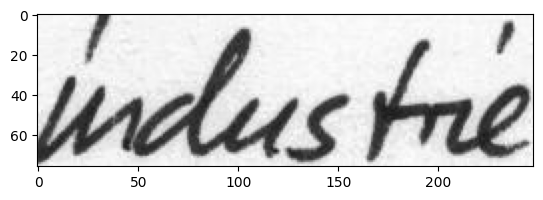

In [42]:
import requests
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

# Load data from IAM database
URL = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
model_name = 'microsoft/trocr-small-handwritten'
image = Image.open(requests.get(URL, stream=True).raw).convert('RGB')

processor = TrOCRProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# Generate text from pretrained model
Inputs = processor(images=image, return_tensors='pt').pixel_values
Generate = model.generate(Inputs)
Outputs = processor.batch_decode(Generate, skip_special_tokens=True)[0]

# Show the result
dash_line = ' '.join('-' for _ in range(100))

print(f'Model Result:\n{Outputs}')
print(dash_line)
print(f"Handwriting Image:\n{plt.imshow(image)}")
plt.show()
